# Read in the data

In [1]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

#schools/{0}?, format(f)?, 
for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    #clever way of naming dataframes
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)#axis?

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)#regex pattern?
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()#strip necessary/function?
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")# errors = coerce?
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

Barplot of correlations on survey data

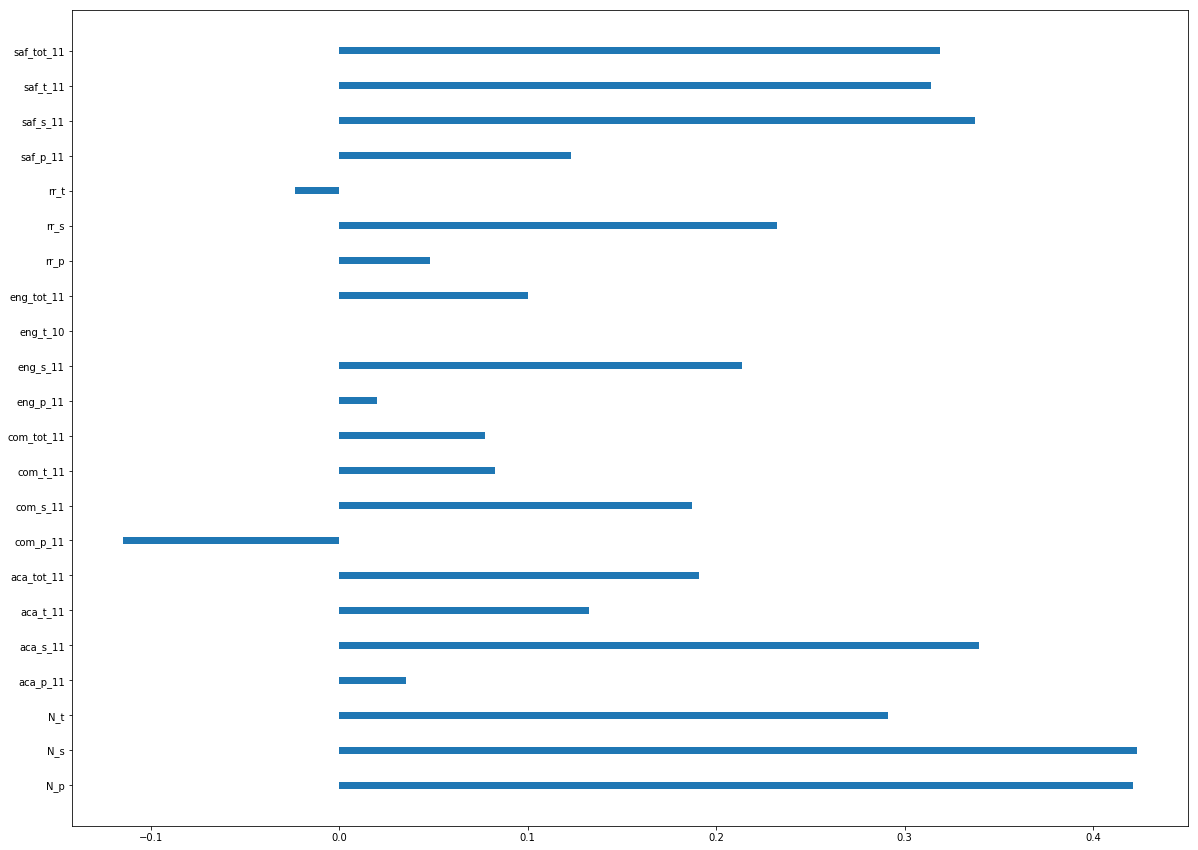

In [10]:
import matplotlib.pyplot as plt

#bar_heights = norm_reviews[num_cols].iloc[0].values
#bar_positions = arange(5) + 0.75
fig, ax = plt.subplots(figsize=(20,15))


s_correlations = correlations[survey_fields][1:]
    
#print(s_correlations)
ax.barh(survey_fields[1:],s_correlations,.2)
#ax.set_xticklabels(survey_fields[1:],rotation=90)
plt.show()
    


+ve correlations exist between Student, parent and teacher response rate, Total number of teacher respondents and safety total and student

safety is a surprising correlation.

Scatter plot of Safety scores and sat scores

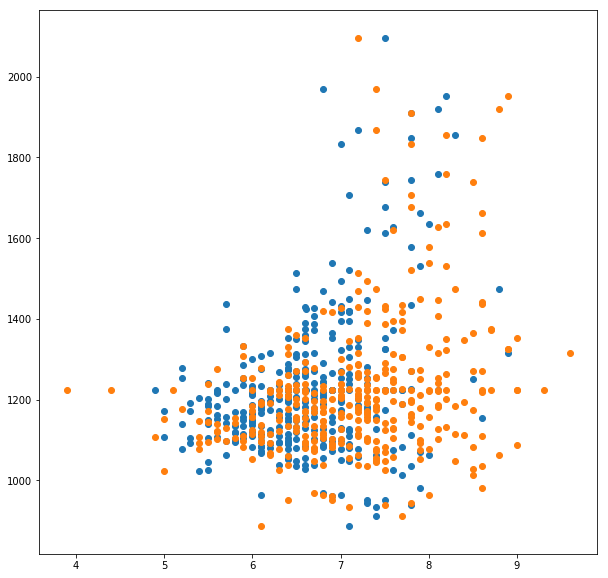

In [12]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(combined['saf_s_11'],combined['sat_score'])
ax.scatter(combined['saf_t_11'],combined['sat_score'])
plt.show()

Only schools with a 7 or above safety rating register an sat score above 1400. Indicates a minimum level of safety required for success, necessary but not sufficient.

In [34]:
#average safety scores for each district
group = combined.groupby("school_dist")
group_safety_ave = group['saf_s_11'].agg(numpy.mean)
print(group_safety_ave)

districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)
print(districts)



school_dist
01    6.768611
02    6.910660
03    6.716667
04    6.885714
05    6.314286
06    6.950000
07    6.800000
08    6.364697
09    6.655000
10    6.577273
11    6.186667
12    7.116667
13    6.407692
14    6.685714
15    6.177778
16    5.875000
17    6.007143
18    6.190909
19    6.150000
20    7.120000
21    6.390909
22    7.025000
23    6.233333
24    7.107692
25    6.912500
26    6.760000
27    6.390000
28    6.627273
29    6.075000
30    7.033333
31    6.530000
32    6.766667
Name: saf_s_11, dtype: float64
   school_dist  SAT Critical Reading Avg. Score  SAT Math Avg. Score  \
0           01                       441.833333           473.333333   
1           02                       426.619092           444.186256   
2           03                       428.529851           437.997512   
3           04                       402.142857           416.285714   
4           05                       427.159915           438.236674   
5           06                       382.0119

/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


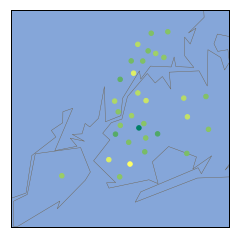

In [36]:
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()
m.scatter(longitudes, latitudes, s=20, zorder=2, latlon=True, c=districts["saf_t_11"], cmap='summer')
plt.show()

Northern Brooklyn seems to be the least safe which fits with google safety map

Bar plot of correlations between race percentage at each school and SAT scores.

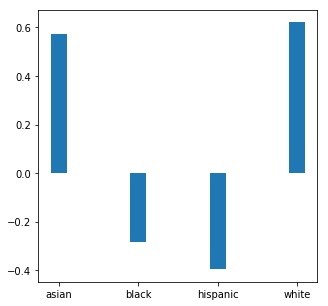

In [47]:
fig, ax = plt.subplots(figsize=(5,5))

races = ['white','asian','black','hispanic']
race_corr = [correlations['white_per'],correlations['asian_per'],correlations['black_per'],correlations['hispanic_per']]
ax.bar(races,race_corr, .2)
plt.show()

SAT very strongly positively correlated with white and asian percentage. negatively correlated with black and hispanic. 

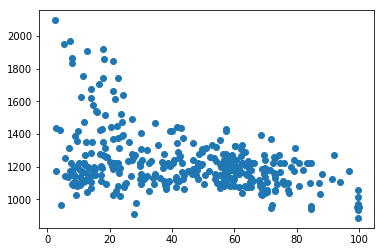

In [52]:
fig, ax = plt.subplots()
ax.scatter(combined['hispanic_per'],combined['sat_score'])
plt.show()

above 50% hispanic caps score at 1400. averape score for 100% hispanic is less than 1000

In [55]:
high_hispanic = combined[combined['hispanic_per'] > 95]
print(high_hispanic['school_name'])

44                         Manhattan Bridges High School
82      Washington Heights Expeditionary Learning School
89     Gregorio Luperon High School for Science and M...
125                  Academy for Language and Technology
141                International School for Liberal Arts
176     Pan American International High School at Monroe
253                            Multicultural High School
286               Pan American International High School
Name: school_name, dtype: object


Schools are for immigrants, so english level will be poor

In [57]:
low_hispanic = combined[combined['hispanic_per'] < 10]
low_hispanic = combined[combined['sat_score'] > 1800]
print(low_hispanic['school_name'])

5                         Bard High School Early College
37                                Stuyvesant High School
79     High School for Mathematics, Science and Engin...
151                         Bronx High School of Science
155    High School of American Studies at Lehman College
187                       Brooklyn Technical High School
302                          Townsend Harris High School
327    Queens High School for the Sciences at York Co...
356                  Staten Island Technical High School
Name: school_name, dtype: object


very good schools, ranking top in NYC

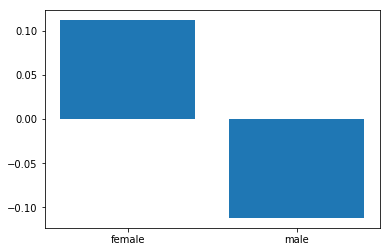

In [61]:
fig, ax = plt.subplots()

genders = ['male','female']
gender_corr = [correlations['male_per'],correlations['female_per']]

ax.bar(genders, gender_corr)
plt.show()

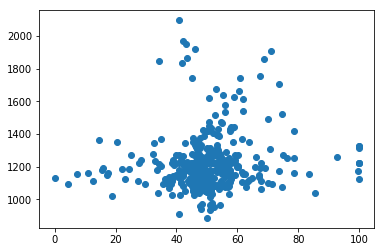

In [62]:
fig,ax = plt.subplots()

ax.scatter(combined['female_per'],combined['sat_score'])
plt.show()

In [63]:
high_female = combined[combined['female_per']>60]
high_female = combined[combined['sat_score']>1700]
print(high_female['school_name'])

5                         Bard High School Early College
26                         Eleanor Roosevelt High School
37                                Stuyvesant High School
60                                    Beacon High School
61     Fiorello H. LaGuardia High School of Music & A...
79     High School for Mathematics, Science and Engin...
151                         Bronx High School of Science
155    High School of American Studies at Lehman College
187                       Brooklyn Technical High School
198                           Brooklyn Latin School, The
302                          Townsend Harris High School
327    Queens High School for the Sciences at York Co...
356                  Staten Island Technical High School
Name: school_name, dtype: object


very good skills, high crossover with low hispanic in previous cell

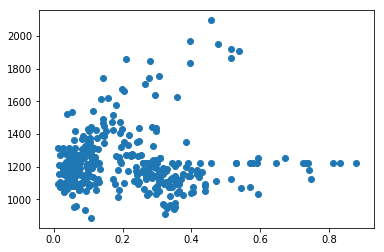

In [65]:
ap_per = combined['AP Test Takers '] / combined['total_enrollment']

fig, ax = plt.subplots()

ax.scatter(ap_per,combined['sat_score'])
plt.show()

surprising that above 55% ap per does not lead to higher sat scores. average sat score for 60%> is under 1200